In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
from tqdm import tqdm
import mapply
mapply.init(n_workers=7, progressbar=True)

import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

# Read in the data
final = pd.read_csv('./dataset/data/final_clean2.csv')

final_no_out = final[final['OUTLIER'] == 0]#

# Remember to the program which 🦆ing columns are objects
cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state', 'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']
final_no_out[cat_cols] = final_no_out[cat_cols].astype('object')#final[cat_cols] = final[cat_cols].astype('object')

numerical = final_no_out.select_dtypes(include=['int64', 'float64'])#numerical = final.select_dtypes(include=['int64', 'float64'])

from sklearn.preprocessing import StandardScaler
local_scaler = StandardScaler()

numerical_scaled = local_scaler.fit_transform(numerical)
numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical.columns)
final_no_out.shape


#numerical_scaled = numerical_scaled.sample(n=10000, random_state=0)

/tmp/ipykernel_11687/781000614.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_no_out[cat_cols] = final_no_out[cat_cols].astype('object')#final[cat_cols] = final[cat_cols].astype('object')


(190977, 61)

In [5]:
def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered

def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned



def k_means(df, n_samples=1, sample_size=1000, k_min=2, k_max=10, return_models=False):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    scoress = []
    models = [[], []]
    samples = [[], []]

    for i in range(0, k_max):
        models.append([])
        samples.append([])

    for i in range(0, n_samples):
        sample = numeric_df.sample(n=sample_size).copy()
        scores = []
        for k in tqdm(range(k_min, k_max+1)):
            kmeans = KMeans(n_clusters=k, n_init=10)
            labels = kmeans.fit_predict(sample)

            if return_models:
                models[k].append(kmeans)
                samples[k].append(sample)
                
            score = silhouette_score(sample, labels)
            scores.append(score)
            scoress.append(scores)

    scoress_array = np.array(scoress)
    mean_scores_array = np.mean(scoress_array, axis=0)
    mean_scores = mean_scores_array.tolist()

    return mean_scores, models, samples


def perform_PCA(df, n_components):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    
    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(numeric_df)

    # Create a PCA model
    pca = PCA(n_components=n_components)

    # Fit the model and transform the data
    df_pca = pca.fit_transform(df_scaled)

    # Create a DataFrame from the PCA results
    columns = [f'PC{i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(df_pca, columns=columns)

    # Display the combined DataFrame
    return df_pca



def find_features(df, columns, col_scores, threshold=0.1):
    prev_max_score = max(col_scores)
    actual_cols = [columns.pop(0)]
    
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=10)
        max_score = max(scores)
        if np.abs(prev_max_score - max_score) > 0.1:#prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            if prev_max_score < max_score:
                prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score



def order_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    #random.shuffle(columns)

    max_scores = []
    for col in columns:
        scores, _, _ = k_means(df=df[[col]], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_scores.append(max(scores))

    # Combine items and scores using zip
    combined = list(zip(columns, max_scores))

    # Sort the combined list based on scores in descending order
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)

    # Extract the sorted items
    sorted_cols = [item for item, score in sorted_combined]
    # Extract the sorted scores
    sorted_scores = [score for item, score in sorted_combined]

    return sorted_cols, sorted_scores



def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced

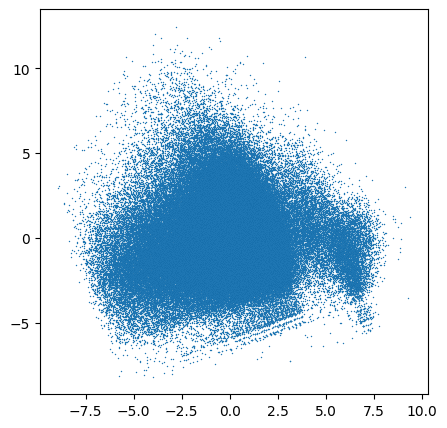

In [6]:
df_pca = perform_PCA(df=numerical_scaled, n_components=20)

plt.figure(figsize=(5, 5))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.show()

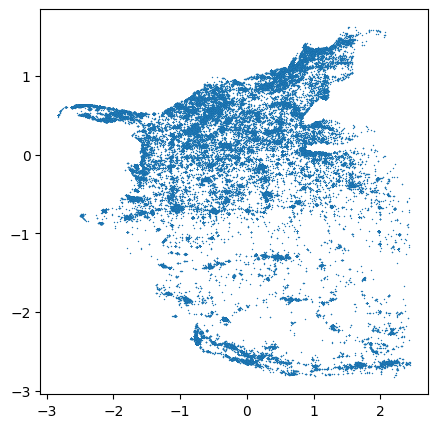

In [8]:
plt.figure(figsize=(5, 5))
plt.scatter(numerical_scaled.iloc[:, 0], numerical_scaled.iloc[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.show()

In [36]:
numerical_r = features_reduction_corr(numerical_scaled, correlation_threshold=0.02)
numerical_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190977 entries, 0 to 190976
Data columns (total 5 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   latitude                           190977 non-null  float64
 1   longitude                          190977 non-null  float64
 2   n_participants_child               190977 non-null  float64
 3   p_participants_child               190977 non-null  float64
 4   month_cd_ratio_participants_child  190977 non-null  float64
dtypes: float64(5)
memory usage: 7.3 MB


In [ ]:
sorted_cols, sorted_scores = order_features(numerical_r)

In [ ]:
cols, score = find_features(numerical_r, sorted_cols, sorted_scores, threshold=0.20)

In [ ]:
k_min = 2
k_max = 10 

scores, models, samples = k_means(numerical_scaled, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

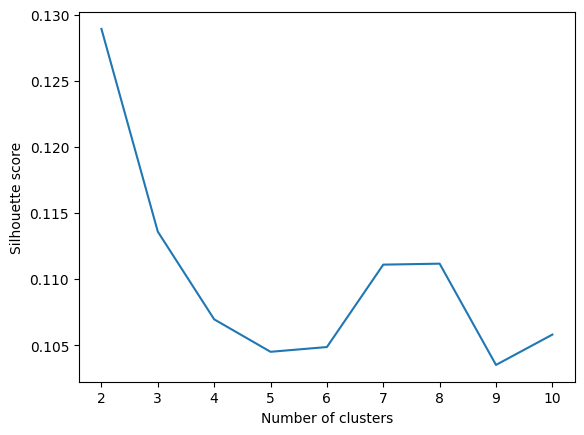

In [10]:
k_min = 2
k_max = 10

plt.plot(range(k_min, k_max+1), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [ ]:
k_min = 2
k_max = 2

scores, models, samples = k_means(numerical_scaled, n_samples=10, sample_size=20000, k_min=k_min, k_max=k_max, return_models=True)
print(scores)

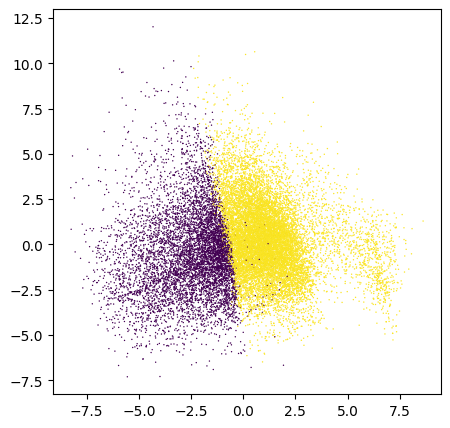

In [20]:
k = 2
i = 0

df_pca = perform_PCA(df=samples[k][i], n_components=5)

plt.figure(figsize=(5, 5))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=models[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
plt.show()

In [38]:
k_min = 2
k_max = 10 

scores, models, samples = k_means(numerical_r, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:21<00:00,  2.41s/it]


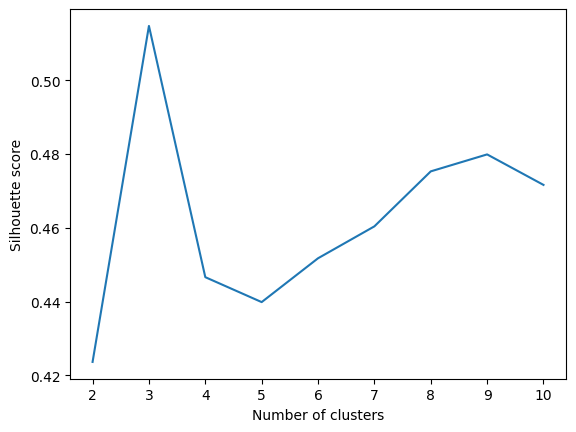

In [39]:
k_min = 2
k_max = 10

plt.plot(range(k_min, k_max+1), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [27]:
k_min = 3
k_max = 3

scores, models, samples = k_means(numerical_r, n_samples=10, sample_size=20000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


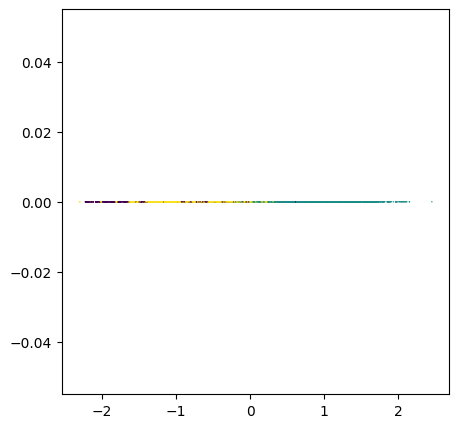

In [43]:
k = 3
i = 0

df_pca = perform_PCA(df=samples[k][i], n_components=5)

plt.figure(figsize=(5, 5))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 4], c=models[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
plt.show()

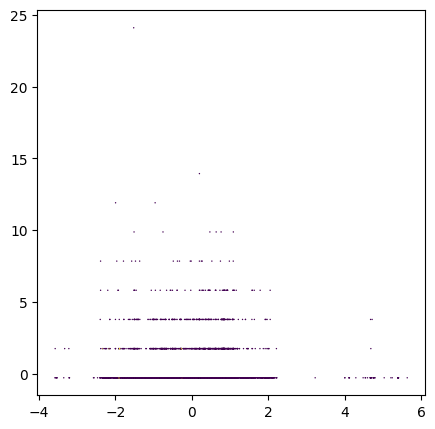

In [70]:
k = 2
i = 0

plt.figure(figsize=(5, 5))
plt.scatter(samples[k][i].iloc[:, 0], samples[k][i].iloc[:, 4], c=models[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
plt.show()

In [52]:
k_min = 2
k_max = 10 

scores, models, samples = k_means(numerical_r[sorted_cols[0:4]], n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:22<00:00,  2.51s/it]


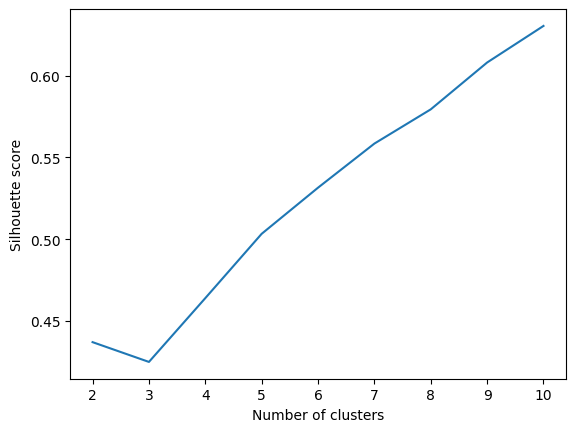

In [53]:
k_min = 2
k_max = 10

plt.plot(range(k_min, k_max+1), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

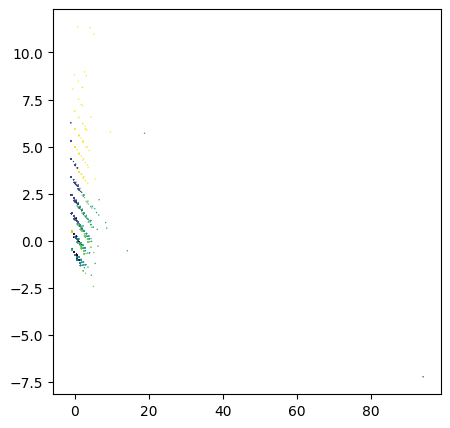

In [55]:
k = 10
i = 0

df_pca = perform_PCA(df=samples[k][i], n_components=2)

plt.figure(figsize=(5, 5))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=models[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
plt.show()

In [11]:
k_min = 2
k_max = 10 

scores, models, samples = k_means(numerical_scaled, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:27<00:00,  3.06s/it]


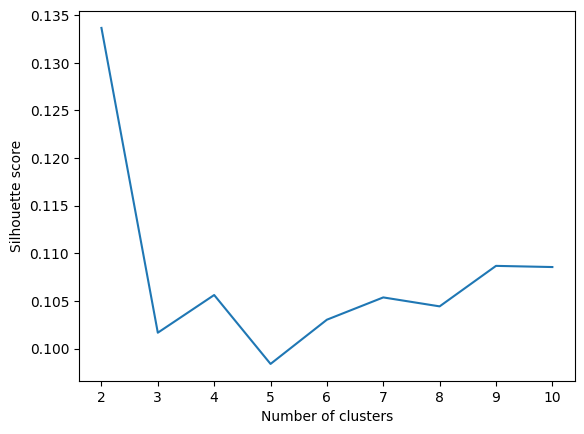

In [12]:
k_min = 2
k_max = 10

plt.plot(range(k_min, k_max+1), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [86]:
def mean_variance_across_clusters(df, model):
    labels = model.labels_
    cluster_variances = []

    for cluster_label in np.unique(labels):
        # Select data points belonging to the current cluster
        cluster_data = df[labels == cluster_label]

        # Compute variance for each feature within the cluster
        feature_variances = np.var(cluster_data, axis=0)

        # Append the feature variances to the list
        cluster_variances.append(feature_variances)

    # Step 4: Calculate the mean variance of each feature across all clusters
    mean_variances = np.mean(cluster_variances, axis=0)

    return mean_variances

In [87]:
mean_variances = mean_variance_across_clusters(samples[2][0], models[2][0])

columns = numerical_scaled.columns.tolist()
# Combine items and scores using zip
combined = list(zip(columns, mean_variances))

# Sort the combined list based on scores in increasing order
sorted_combined = sorted(combined, key=lambda x: x[1], reverse=False)

# Extract the sorted items
sorted_cols = [item for item, score in sorted_combined]

print(mean_variances)

[1.00158996 0.96603838 0.73150172 0.75541443 0.87069761 4.60896476
 1.75130035 1.00556686 1.20466489 1.42933781 0.99581088 1.37708429
 1.32231665 1.13606847 1.3017343  1.02316096 0.97544591 0.99105535
 0.99691799 0.97466678 1.07124315 1.07124315 4.47603073 1.28261387
 0.60697487 0.88696007 0.99871164 0.98854818 0.92957022 0.77477377
 0.80447336 0.91013967 1.14399049 1.12045428 4.47376345 2.09480802
 0.88303798 1.0710379  0.94517654 1.23149591 0.95268594 0.94493522
 1.09339803 1.00627813 0.98944593 0.98944593 1.02226259 1.04281079
 0.98258769 1.00245439]


In [88]:
sorted_cols

['p_participants_adult',
 'min_age_participants',
 'avg_age_participants',
 'month_cd_change_min_age_participants',
 'month_cd_change_avg_age_participants',
 'max_age_participants',
 'month_cd_ratio_participants_adult',
 'p_killed',
 'month_cd_change_max_age_participants',
 'p_unharmed',
 'month_cd_incidents',
 'month_cd_ratio_injured',
 'month_cd_ratio_unharmed',
 'longitude',
 'state_population',
 'povertyPercentage',
 'cd_month_NON_SHOOTING',
 'p_arrested',
 'percentage_republican',
 'percentage_democrat',
 'candidatevotes',
 'n_killed',
 'totalvotes',
 'p_injured',
 'latitude',
 'cd_month_OTHER',
 'n_participants_adult',
 'cd_population',
 'cd_month_SHOT_INJURED',
 'timestamp',
 'cd_month_SHOT_DEAD',
 'month_cd_ratio_killed',
 'p_females',
 'p_males',
 'month_cd_votes_incidents',
 'month_cd_ratio_females',
 'n_unharmed',
 'month_cd_ratio_males',
 'n_males',
 'month_cd_ratio_arrested',
 'p_participants_teen',
 'n_participants',
 'n_arrested',
 'n_injured',
 'n_females',
 'n_particip

In [89]:
k_min = 2
k_max = 10 

scores, models, samples = k_means(numerical_scaled[sorted_cols[0:5]], n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:21<00:00,  2.37s/it]


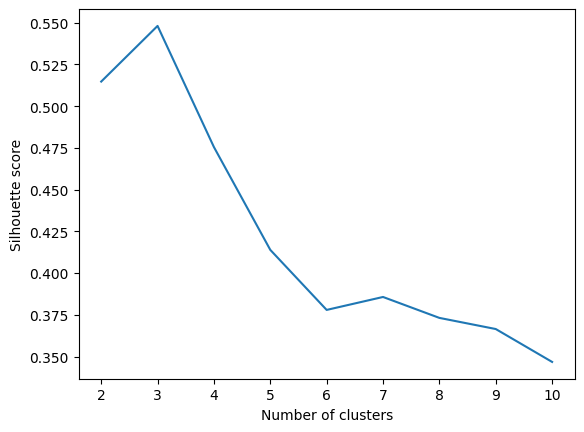

In [90]:
k_min = 2
k_max = 10

plt.plot(range(k_min, k_max+1), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

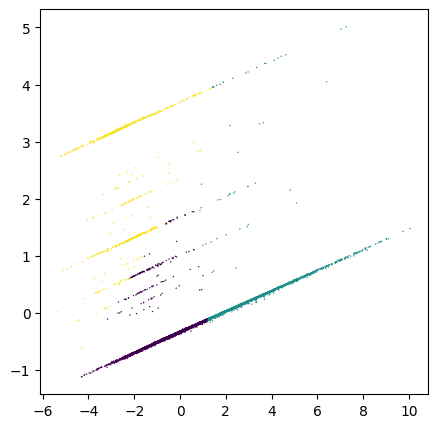

In [107]:
k = 3
i = 0

df_pca = perform_PCA(df=samples[k][i], n_components=5)

plt.figure(figsize=(5, 5))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=models[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
plt.show()